## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2024.

# Assignment 1, Task 3: Multilayer Perceptron (MLP)
This is the third part of the assignment. You will get to implement MLP using tensorflow

In [3]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import pickle

from tensorflow.keras.datasets import fashion_mnist

# Plot configurations
%matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

## Load Data

In [5]:
# Load the raw Fashion-MNIST data.
train, test = fashion_mnist.load_data()

X_train_raw, y_train = train
X_test_raw, y_test = test

X_train = X_train_raw.reshape((X_train_raw.shape[0], X_train_raw.shape[1]**2))
X_test = X_test_raw.reshape((X_test_raw.shape[0], X_test_raw.shape[1]**2))

# Data organizations:
# Train data: 58000 samples from original training set of 60,000
# Validation data: 2000 samples from original training set: 58,000~60,000
# Test data: 10000 samples from original test set
# Development data (for gradient check): 100 from the training set

num_training = 58000
num_validation = 2000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

(58000, 784) (2000, 784) (10000, 784) (100, 784)
Train data shape:  (58000, 784)
Train labels shape:  (58000,)
Validation data shape:  (2000, 784)
Validation labels shape:  (2000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)
Development data shape: (100, 784)
Development data shape (100,)


## Part 1: Tensorflow MLP (10%)
In this part, you will use tensorflow modules to implement an MLP. We provide a demo of a two-layer net, the style of is referenced from https://www.tensorflow.org/guide/keras and https://www.tensorflow.org/guide/eager. 

You need to implement a MLP with 4 layers in a similar style.

### Demo: Two-layer MLP in Tensorflow

In [8]:
## Demo: Two-layer net in tensorflow (eager execution mode)
hidden_dim = 300
reg_tf = tf.constant(0.01)

# Define a tf.keras.Model class
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.W1 = tf.Variable(1e-2*np.random.rand(X_train.shape[1], hidden_dim).astype('float32'))
        self.b1 = tf.Variable(np.zeros((hidden_dim,)).astype('float32'))
        self.W2 = tf.Variable(1e-2*np.random.rand(hidden_dim, 20).astype('float32'))
        self.b2 = tf.Variable(np.zeros((20,)).astype('float32'))
    def call(self, inputs):
        """Run the model."""
        h1 = tf.nn.relu(tf.matmul(inputs, self.W1) + self.b1)
        out = tf.matmul(h1, self.W2) + self.b2
        return out

# Define and calculate loss function (Note that in eager execution, loss must be in a function)
def loss(model, inputs, targets, reg = tf.constant(0.01)):
    out = model(inputs)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= out, labels=tf.one_hot(targets,20))
    L2_loss = tf.nn.l2_loss(model.W1) + tf.nn.l2_loss(model.W2)
    return tf.reduce_mean(cross_entropy) + reg * L2_loss

# Calculate gradients for all variables using tf.GradientTape
def grad(model, inputs, targets, reg = tf.constant(0.01)):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, reg=reg)
    return tape.gradient(loss_value, [model.W1, model.b1, model.W2, model.b2])

# Calculate classification accuracy
def eval_acc(model, inputs, targets):
    correct_prediction = tf.equal(targets, tf.cast(tf.argmax(model(inputs),1), tf.uint8))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

num_train = 58000
batch_size = 500
num_batch = num_train//batch_size
num_epochs = 15
model = Model()
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

for e in range(num_epochs):
    for i in range(num_batch):
        batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
        x_tf = tf.Variable(batch_xs, dtype = tf.float32)
        y_tf = tf.Variable(batch_ys, dtype = tf.uint8)
        
        grads = grad(model, x_tf, y_tf, reg_tf)
        # Optimization based on calculated gradients 
        optimizer.apply_gradients(zip(grads, [model.W1, model.b1, model.W2, model.b2]))

    x_tf = tf.Variable(X_val, dtype = tf.float32)
    y_tf = tf.Variable(y_val, dtype = tf.uint8)
    accuracy = eval_acc(model, x_tf, y_tf)
    val_acc = accuracy.numpy()
    print('epoch {}: valid acc = {}'.format(e+1, val_acc))

x_tf = tf.Variable(X_test, dtype = tf.float32)
y_tf = tf.Variable(y_test, dtype = tf.uint8)
accuracy = eval_acc(model, x_tf, y_tf)
test_acc = accuracy.numpy()
print('test acc = {}'.format(test_acc))

epoch 1: valid acc = 0.7484999895095825
epoch 2: valid acc = 0.7860000133514404
epoch 3: valid acc = 0.8134999871253967
epoch 4: valid acc = 0.8379999995231628
epoch 5: valid acc = 0.8475000262260437
epoch 6: valid acc = 0.8544999957084656
epoch 7: valid acc = 0.8550000190734863
epoch 8: valid acc = 0.8650000095367432
epoch 9: valid acc = 0.8690000176429749
epoch 10: valid acc = 0.8669999837875366
epoch 11: valid acc = 0.8694999814033508
epoch 12: valid acc = 0.8725000023841858
epoch 13: valid acc = 0.875
epoch 14: valid acc = 0.875
epoch 15: valid acc = 0.8769999742507935
test acc = 0.8634999990463257


### Create Deeper Network

<span style="color:red"><strong>TODO</strong></span>: Create your MLP in tensorflow. Since you are going to create a deeper neural network, it is recommended to use "list" to store your network parameters (weights and bias). Consider using a loop to create your MLP network.

<span style="color:red"><strong>HINT</strong></span>: Copy the code above and make necessary changes in model definition.

In [11]:
# Create you MLP using TensorFlow functions.

############################################################################
#                         START OF YOUR CODE                               #
############################################################################

hidden_dims = [300,300]
outdims = 20
reg_tf = tf.constant(0.01)

# Define a tf.keras.Model class
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()

        self.num_layers = len(hidden_dims) + 1
        dims = [X_train.shape[1]] + hidden_dims + [outdims]

        self.W = []
        self.b = []
        
        for i in range(len(dims) - 1):
            W = tf.Variable(1e-2*np.random.rand(dims[i], dims[i+1]).astype('float32'))
            b = tf.Variable(np.zeros((dims[i+1]),).astype('float32'))
            self.W.append(W)
            self.b.append(b)
    
    def call(self, inputs):
        """Run the model."""
        for i in range(len(self.W) - 1):
            h = tf.nn.relu(tf.matmul(inputs, self.W[i]) + self.b[i])
            inputs = h
        out = tf.matmul(inputs, self.W[-1]) + self.b[-1]
            
        return out

# Define and calculate loss function (Note that in eager execution, loss must be in a function)
def loss(model, inputs, targets, reg = tf.constant(0.01)):
    out = model(inputs)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= out, labels=tf.one_hot(targets,20))
    L2_loss = sum([tf.nn.l2_loss(W) for W in model.W])
    return tf.reduce_mean(cross_entropy) + reg * L2_loss

# Calculate gradients for all variables using tf.GradientTape
def grad(model, inputs, targets, reg = tf.constant(0.01)):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, reg=reg)
    return tape.gradient(loss_value, model.W + model.b)

# Calculate classification accuracy
def eval_acc(model, inputs, targets):
    correct_prediction = tf.equal(targets, tf.cast(tf.argmax(model(inputs),1), tf.uint8))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

num_train = 58000
batch_size = 500
num_batch = num_train//batch_size
num_epochs = 15
model = Model()
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)

for e in range(num_epochs):
    for i in range(num_batch):
        batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
        x_tf = tf.Variable(batch_xs, dtype = tf.float32)
        y_tf = tf.Variable(batch_ys, dtype = tf.uint8)
        
        grads = grad(model, x_tf, y_tf, reg_tf)
        # Optimization based on calculated gradients 
        optimizer.apply_gradients(zip(grads, model.W + model.b))

    x_tf = tf.Variable(X_val, dtype = tf.float32)
    y_tf = tf.Variable(y_val, dtype = tf.uint8)
    accuracy = eval_acc(model, x_tf, y_tf)
    val_acc = accuracy.numpy()
    print('epoch {}: valid acc = {}'.format(e+1, val_acc))

x_tf = tf.Variable(X_test, dtype = tf.float32)
y_tf = tf.Variable(y_test, dtype = tf.uint8)
accuracy = eval_acc(model, x_tf, y_tf)
test_acc = accuracy.numpy()
print('test acc = {}'.format(test_acc))

############################################################################
#                          END OF YOUR CODE                                #
############################################################################

epoch 1: valid acc = 0.1665000021457672
epoch 2: valid acc = 0.1665000021457672
epoch 3: valid acc = 0.2029999941587448
epoch 4: valid acc = 0.17149999737739563
epoch 5: valid acc = 0.19099999964237213
epoch 6: valid acc = 0.19750000536441803
epoch 7: valid acc = 0.30000001192092896
epoch 8: valid acc = 0.22200000286102295
epoch 9: valid acc = 0.28700000047683716
epoch 10: valid acc = 0.2815000116825104
epoch 11: valid acc = 0.27399998903274536
epoch 12: valid acc = 0.2904999852180481
epoch 13: valid acc = 0.34599998593330383
epoch 14: valid acc = 0.36149999499320984
epoch 15: valid acc = 0.3779999911785126
test acc = 0.3763999938964844


## Part 2: Introduction to TensorFlow.keras (10%)

As you can see, when the network structure becomes larger, it is hard to handle variables from every layer. Here we introduce the `tf.keras` tool to build the network in a much simpler way. You may want to use it in your project.

<span style="color:red"><strong>TODO</strong></span>: Follow this official example: https://www.tensorflow.org/datasets/keras_example#step_2_create_and_train_the_model to build an MLP and train it. 

*You should keep the same optimizer (SGD) and loss function (cross entropy) as in the previous task.*

**Note:** Since we want to use our own dataset, we will not use the `tfds.load` method to load the data this time. 

You need to check the usage of [`model.fit()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) and feed the model with our own data.

**Tips:**
* Softmax is also registered as a layer operation in tf.keras.
* You can use `model.summary()` to visualize the model after you build it.
* Use `verbose=2` in `model.fit()` to get similar training logs

In [14]:
############################################################################
# TODO: Build the model with tf.keras.models.Sequential                    #
############################################################################
############################################################################
#                         START OF YOUR CODE                               #
############################################################################

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(784,)),
  tf.keras.layers.Dense(300, activation='relu'),
  tf.keras.layers.Dense(200, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(50, activation='relu'),
  tf.keras.layers.Dense(10)
])

############################################################################
#                          END OF YOUR CODE                                #
############################################################################



############################################################################
# TODO: Compile the model, set optimizer and loss                          #
############################################################################
############################################################################
#                         START OF YOUR CODE                               #
############################################################################

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

############################################################################
#                          END OF YOUR CODE                                #
############################################################################




############################################################################
# TODO: Train the model with our own dataset                               #
############################################################################
############################################################################
#                         START OF YOUR CODE                               #
############################################################################

model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data = (X_val,y_val),
)

############################################################################
#                          END OF YOUR CODE                                #
############################################################################


Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1813/1813 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2.1738 - sparse_categorical_accuracy: 0.7023 - val_loss: 0.5211 - val_sparse_categorical_accuracy: 0.8025
Epoch 2/100
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4541 - sparse_categorical_accuracy: 0.8358 - val_loss: 0.4420 - val_sparse_categorical_accuracy: 0.8555
Epoch 3/100
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 2s 986us/step - loss: 0.4096 - sparse_categorical_accuracy: 0.8523 - val_loss: 0.4077 - val_sparse_categorical_accuracy: 0.8515
Epoch 4/100
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 2s 987us/step - loss: 0.3997 - sparse_categorical_accuracy: 0.8563 - val_loss: 0.4270 - val_sparse_categorical_accuracy: 0.8410
Epoch 5/100
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3642 - sparse_categorical_accuracy: 0.8680 - val_loss: 0.3960 - val_sparse_categorical_accuracy: 0.8570
Epoch 6/100
1813/1813 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3511 - sparse_categorical_accuracy: 0.8731 - val_loss: 0.3712 - val_sparse_categorical_accuracy: 0

KeyboardInterrupt: 

## Part 3: t-SNE (5%)

**t-SNE** is is a machine learning algorithm for nonlinear dimensionality reduction developed by *Geoffrey Hinton* and *Laurens van der Maaten*. It can be used as a good way of visualizing high-dimensional data in 2D.

Here we show its application for CIFAR100. Later it will be re-used in a CNN network. Experimenting with t-SNE can be fun. One thing to try is to visualize the output of each layer of MLP to observe the differences.

In [25]:
from utils.train_funcs import train, test
from utils.classifiers.mlp import MLP

In [27]:
# Load the raw Fashion-MNIST data.
train_data, test_data = fashion_mnist.load_data()

X_train_raw, y_train = train_data
X_test_raw, y_test = test_data

X_train = X_train_raw.reshape((X_train_raw.shape[0], X_train_raw.shape[1]**2))
X_test = X_test_raw.reshape((X_test_raw.shape[0], X_test_raw.shape[1]**2))

# Data organizations:
# Train data: 58000 samples from original training set of 60,000
# Validation data: 2000 samples from original training set: 58,000~60,000
# Test data: 10000 samples from original test set
# Development data (for gradient check): 100 from the training set
num_training = 58000
num_validation = 2000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

(58000, 784) (2000, 784) (10000, 784) (100, 784)
Train data shape:  (58000, 784)
Train labels shape:  (58000,)
Validation data shape:  (2000, 784)
Validation labels shape:  (2000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)
Development data shape: (100, 784)
Development data shape (100,)


### t-SNE of Original Data

In [29]:
!pip install scikit-learn

<font color="red">**NOTE**</font>: You may have to restart the kernel before proceeding.

it takes 0.9974887371063232 seconds


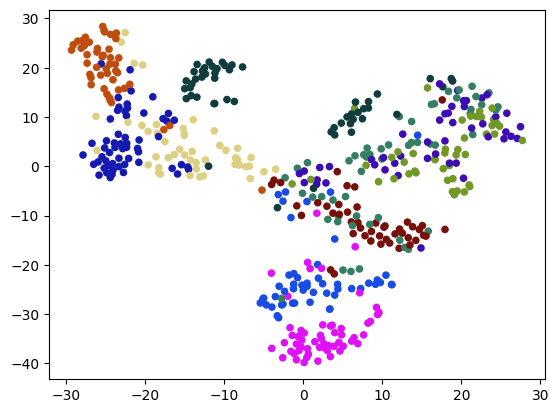

In [30]:
from sklearn.manifold import TSNE

random_select = np.random.choice(10000, 500, replace=False)
X = X_test_raw[random_select,:,:].reshape(500,X_train.shape[1]).astype('float')/255.0

tic = time.time()
Y = TSNE(n_components=2, perplexity=25.0).fit_transform(X)
print("it takes {} seconds".format(time.time()-tic))

## Visualize t-SNE of original data
labels = y_test[random_select]
colors = np.random.rand(20,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()

### t-SNE of Data After Two Hidden Layers

Visualize the t-SNE of data after going through MLP. In the visualization result, you should find that the t-SNE of the original data points are rather jumbled up. However, visualization of data after the trained two-layer networks are clearly separated into multiple clusters in a 2D panel.

In [33]:
# Define MLP model
model = MLP(input_dim=X_train.shape[1], hidden_dims=[100], num_classes=20, reg=0.1, weight_scale=1e-3)

num_epoch = 10
batch_size = 200
lr = 1e-3
verbose = False
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 290
epoch 1: valid acc = 0.8135, new learning rate = 0.00095
epoch 2: valid acc = 0.85, new learning rate = 0.0009025
epoch 3: valid acc = 0.858, new learning rate = 0.000857375
epoch 4: valid acc = 0.8615, new learning rate = 0.0008145062499999999
epoch 5: valid acc = 0.8665, new learning rate = 0.0007737809374999998
epoch 6: valid acc = 0.8705, new learning rate = 0.0007350918906249997
epoch 7: valid acc = 0.871, new learning rate = 0.0006983372960937497
epoch 8: valid acc = 0.8725, new learning rate = 0.0006634204312890621
epoch 9: valid acc = 0.8785, new learning rate = 0.000630249409724609
epoch 10: valid acc = 0.8795, new learning rate = 0.0005987369392383785
test acc: 0.8687


0.8687

<span style="color:red"><strong>TODO</strong></span>: Visualize data that is passed through the MLP model defined above using t-SNE. 

In [36]:
# Run tSNE
tic = time.time()

#############################################################################
#                          START OF YOUR CODE                               #
# Hint: Pass data through affine and dense layers (model.layers) and then   # 
# apply softmax to obtain output of the MLP model.                          #
#############################################################################

import sys
sys.path.append('/Users/lindseyma/Documents/GitHub/e4040-2024fall-assign1-Lindsey-cyber/utils/classifiers')
from softmax import softmax

X = X_train
for layer in model.layers:
    X = layer.feedforward(X)
X = softmax(X)

Y = TSNE(n_components=2, perplexity=25.0).fit_transform(X)

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

print("it takes {} seconds".format(time.time()-tic))

it takes 100.27235913276672 seconds


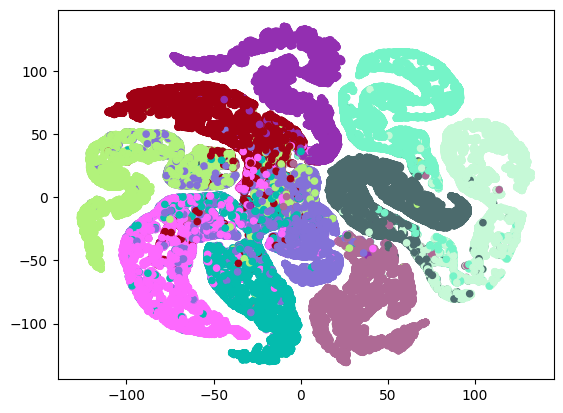

In [37]:
# Visualize t-SNE 2D representation of data after two hidden layers
#############################################################################
#                          START OF YOUR CODE                               #
# Hint: See t-SNE visualization of original data.                           #
#############################################################################

## Visualize t-SNE of original data
labels = y_train
colors = np.random.rand(20,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

<span style="color:red"><strong>TODO</strong></span>: Try tuning the parameters of t-SNE. Do visualization of the new t-SNE of the data.

In [38]:
# Tune the parameter, show the results.
# Run t-SNE
tic = time.time()

#############################################################################
#                          START OF YOUR CODE                               #
#############################################################################

Y = TSNE(n_components=2, perplexity=100.0).fit_transform(X)

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

print("it takes {} seconds".format(time.time()-tic))

it takes 134.2937409877777 seconds


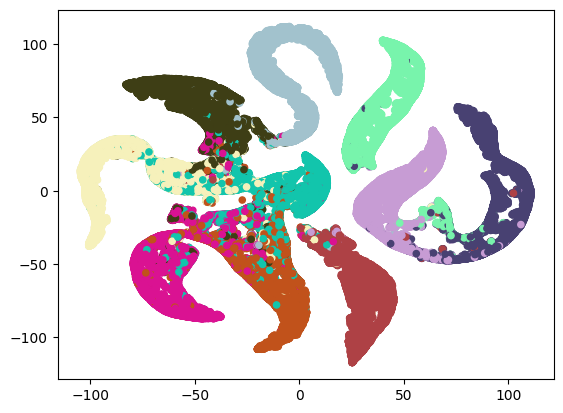

In [39]:
# Visualize t-SNE 2D representation of data after two hidden layers
#############################################################################
#                          START OF YOUR CODE                               #
#############################################################################

## Visualize t-SNE of original data
labels = y_train
colors = np.random.rand(20,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################